#### --------------------------------------------------------------------------------------------------------------
# Seminario Transducción electromecánica, 
# fundamentos, tecnologías y aplicaciones 
# en sensores y actuadores ultrasónicos.
##  Universidad Miguel Hernandez, 
### Elche, 17 noviembre 2016
### Tomás Gómez Álvarez-Arenas
#### ITEFI-CSIC
##### www.us-biomat.com
#### --------------------------------------------------------------------------------------------------------------

# Impedancia eléctrica de resonadores piezoelectricos unidimensionales

## Importamos algunos módulos que necesitamos y definimos algunas magnitudes globales

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
j = np.complex(0,1)
pi = 3.141592654

## Definimos algunas clases y funciones
### 1. Definimos una clase para contener las propiedades del material

In [2]:
class material(object):
    """Define una clase que contiene las propiedades del material explicitadas anteriormente y otorga un nombre"""
    j = np.complex(0,1)
    def __init__(self,Matname, data):
        self.Matname = Matname
        self.eps33_T = data[0]*8.85e-12  # Constante dielectrica
        self.eps33_S = data[1]*8.85e-12  # Constante dielectrica
        self.beta33_S = data[2]/8.85e-12 # Inversa de la constante dielectrica
        self.beta33_T = data[3]/8.85e-12 # Inversa de la constante dielectrica
        self.d31 = data[4]               # Constante piezoeléctrica
        self.g33 = data[5]               # Constante piezoeléctrica
        self.h33 = data[6]               # Constante piezoeléctrica
        self.s11_E = data[7]             # Constante elástica
        self.s33_D = data[8]             # Constante elástica
        self.c33_D = data[9]             # Constante elástica
        self.rho = data[10]              # Densidad
        self.QE = data[11]               # Factor Q de perdidas electricas
        self.QM = data[12]               # Factor Q de perdidas mecanicas
    
    def kt(self):
        return self.h33 *( self.eps33_S*(1+j/self.QE) / (self.c33_D*(1+j/self.QM)))** (1.0/2.0)
    
    def k31(self):
        return (self.d31 ** 2 / (self.s11_E * self.eps33_T*(1+j/self.QE))) ** (1./2.)
    
    def v_D(self):
        return (self.c33_D*(1+j/self.QM)/ self.rho)**(1./2.)
    
    def vb_E(self):
        return (1./(self.rho * self.s11_E*(1+j/self.QM)))**(1./2.)
                
    def vb_D(self):
        return (1/(self.rho * self.s33_D*(1+j/self.QM)))**(1./2.)
  

### 2. Definimos una clase para determinar la forma del objeto piezoelectrico y la geometría del campo electrico

In [3]:
class Forma(object):
    """Establece la forma del elemento piezoelectrico"""
    def __init__(self,l,w,t,shape):
        self.l = l
        self.w = w
        self.t = t
        self.shape = shape

### 3. Definimos unas funciones para, dado un material y una geometría, calcular la impedancia electrica y representarla gráficamente

In [4]:
def Impedance(material,Piece,fmin,fmax):
    """Funcion que calcula la impedancia electrica para un material, una forma y un rango de frecuencia"""
    fvec = np.linspace(fmin,fmax,1000)
    #pi = 3.141592654
    #j = np.complex(0,1)
    fang = 2 * pi * fvec
    if Piece.shape == 'Thickness mode thin plate':
        AA1 = fang * Piece.t / (2 * material.v_D())
        AA2 = 1. - material.kt() ** 2. * np.tan(AA1)/AA1
        Cc = Piece.l * Piece.w / (Piece.t * material.beta33_S*(1+j/material.QE))
        
        Z = 1. / (j * fang * Cc) * AA2
        return Z, fvec, material.Matname, Piece.shape

    if Piece.shape == 'Length expander bar E normal to L':
        AA1 = fang * Piece.l / (2 * material.vb_E())
        AA2 = (1. - material.k31() ** 2.) + material.k31() * np.tan(AA1)/AA1
        Cc = (j * fang * Piece.l * Piece.w / Piece.t) * material.eps33_T * (1+j/material.QE)
        
        Z = 1./(Cc * AA2)
        return Z, fvec, material.Matname, Piece.shape 
    
    if Piece.shape == 'Length expander bar E|| L':
        AA1 = fang * Piece.l / (2 * material.vb_D())
        AA2 = Piece.l * (material.g33 ** 2 / material.s33_D + material.beta33_T) - 2 * material.g33 **2 *  material.vb_D() / (material.s33_D * fang) * np.tan(AA1)/AA1
        Cc = (j * fang * Piece.t * Piece.w )
        
        Z = AA2 / Cc
        return Z, fvec, material.Matname, Piece.shape   
    
    
def plot_Z(Z):
    """Funcion que representa graficamente la impedancia calculada"""
    x = Z[1] / 1e6
    plt.semilogy(x,np.abs(Z[0]))
    plt.xlabel('Frecuencia (MHz)')
    plt.ylabel('Modulo Impedancia (Ohm)')
    plt.title(Z[2] + '  ' + Z[3])
    
def desplz(material,Piece,fmin,fmax):
    fvec = np.linspace(fmin,fmax,1000)
    #pi = 3.141592654
    #j = np.complex(0,1)
    fang = 2 * pi * fvec
    if Piece.shape == 'Length expander bar E|| L':
        desp = material.vb_D() * material.g33 / fang
        x3 = Piece.l
        AA1 = fang * Piece.l / (2 * material.vb_D())
        AA2 = fang * x3 / (material.vb_D())
        desp = desp * (np.sin(AA2) -np.tan(AA1) * np.cos(AA2) )
        desp = desp / (fang * Piece.t * Piece.w * Impedance(material,Piece,fmin,fmax)[0])
        return desp, fvec, material.Matname, Piece.shape
    
    if Piece.shape == 'Length expander bar E normal to L':
        desp = material.vb_E() * material.d31 / fang
        x3 = Piece.l
        AA1 = fang * Piece.l / (material.vb_E())
        AA2 = fang * x3 / (material.vb_E())
        desp = desp * (np.sin(AA2)  + (np.cos(AA1)-1) * np.cos(AA2) / np.sin(AA1) )
        return desp, fvec, material.Matname, Piece.shape
    
def plot_desplz(desp):
    """Funcion que representa graficamente la impedancia calculada"""
    x = desp[1] / 1e6
    plt.semilogy(x,np.abs(desp[0]))
    plt.xlabel('Frecuencia (MHz)')
    plt.ylabel('Desplazamiento')
    plt.title(desp[2] + '  ' + desp[3])
        
    

## Introduzcamos los datos de algunas ceramicas piezoelectricas ampliamente usadas:
### PZT4, PZT5, BaTiO3

In [5]:
PZT5   = material('PZT5',  [1700., 830., 1./1700., 1./830., -171e-12, 24.8e-3, 21.5e8, 16.4e-12, 18.8e-12, 14.7e10, 7750, 50,75])
BaTiO3 = material('BaTiO3',[1700., 1260, 1./1260., 1./1700., -78e-12, 12.6e-3, 15.6e8, 9.1e-12, 9.5e-12, 17.7e10, 5700, 100, 300])
PZT4   = material('PZT4',  [1300., 635,  1./1300., 1./635., -123e-12, 26.1e-3, 26.8e8, 12.3e-12, 15.5e-12, 15.9e10, 7500, 250, 500 ])

## Consideremos algunos ejemplos
## EJEMPLO 1.

### 1. Selecionamos material:

#### PZT5



In [6]:
MAT = PZT5

### 2. Seleccionamos geometría:

#### Lámina delgada polarizada en la dirección del espesor, campo aplicado en la direccón del espesor


In [7]:
Plate1 = Forma(10e-3, 5e-3,1e-3,'Thickness mode thin plate')


### 3. Calculamos y representamos la impedancia
#### Fijamos el rango de frecuencia

In [8]:
fmin = 100e3
fmax = 4e6

#### Calculamos la impedancia eléctrica para el material y la geometría definida

In [9]:
Z0 = Impedance(MAT,Plate1,fmin,fmax)

#### Representamos el modulo de la impedancia contra frecuencia

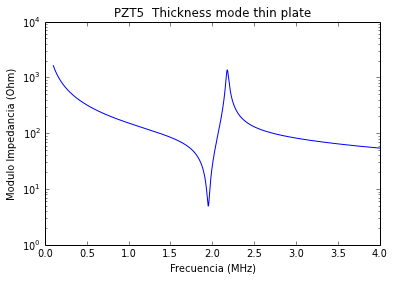

In [10]:
plt.figure()
plot_Z(Z0)
plt.show()

#### Repetimos este mismo calculo para el TiOBa3 y PZT4

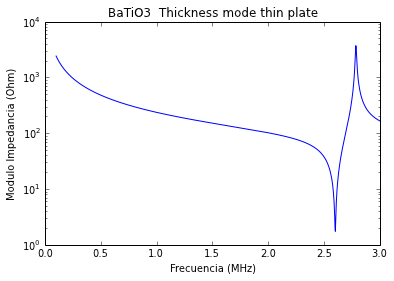

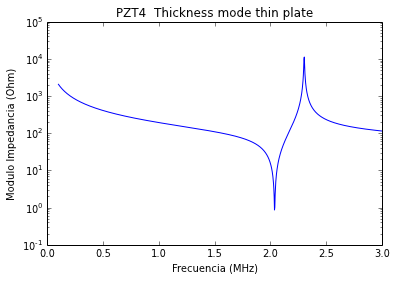

In [12]:
Plate1 = Forma(10e-3, 5e-3,1e-3,'Thickness mode thin plate')
fmin = 100e3
fmax = 3e6
Z1 = Impedance(BaTiO3,Plate1,fmin,fmax)
Z2 = Impedance(PZT4,Plate1,fmin,fmax)

plt.figure()
plot_Z(Z1)
plt.figure()
plot_Z(Z2)
plt.show()



#### Definimos otras geometrías

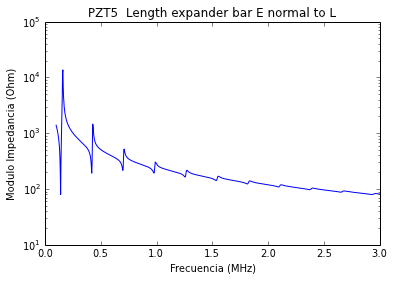

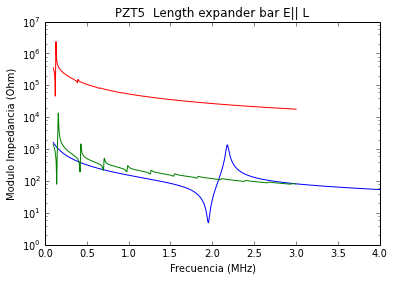

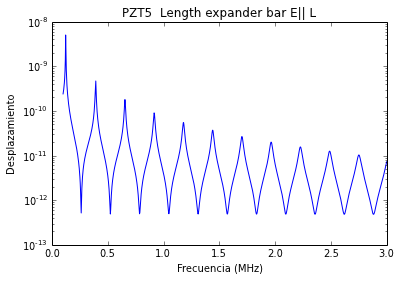

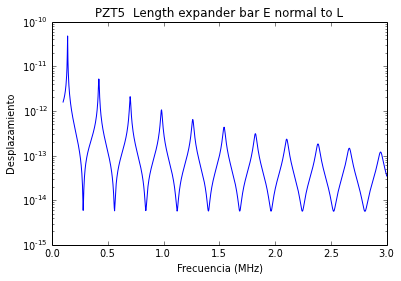

In [14]:
Plate2 = Forma(10e-3, 5e-3,1e-3,'Length expander bar E normal to L')
Z4 = Impedance(PZT5,Plate2,fmin,fmax)
plt.figure()
plot_Z(Z4)
plt.figure()
plot_Z(Z0)
plot_Z(Z4)
Plate3 = Forma(10e-3, 5e-3,1e-3,'Length expander bar E|| L')
Z5 = Impedance(PZT5,Plate3,fmin,fmax)
plot_Z(Z5)
plt.show()
des = desplz(PZT5,Plate3,fmin,fmax)
plt.figure()
plot_desplz(des)
plt.show()
des = desplz(PZT5,Plate2,fmin,fmax)
plt.figure()
plot_desplz(des)
plt.show()
